# Mini-projet n°2 - Conditional VAEs

L'objectif de ce projet est de définir et entraîner un Conditional VAE (CVAE). Nous allons tout d'abord définir ce qu'est un CVAE et la différence avec un VAE, puis définir et entraîner un CVAE sur le dataset Fashin-MNIST.

## Définition d'un CVAE

### Définition d'un VAE

Un Variational AutoEncoder (VAE) est un autoencoder qui cherche à apprendre la distribution des données $x$, en introduisant des variables latentes $z$. produit une distribution de probabilité dans l'espace latent. La partie encodeur va apprendre $q(z|x)$, soit la distribution de $z$, la forme dans l'espace latent, en sachant $x$, la donnée d'entrée. En réalité, on va plutôt poser $z=\mu(x) + \sigma(x) \epsilon$, avec $\epsilon \sim \mathcal{N}(0,1)$. Ainsi, l'encodeur apprendra plutôt l'espérance $\mu$ et le log de l'écart-type $\log(\sigma)$. A l'inverse, la partie décodeur va apprendre $p(x|z)$, soit la distriubtion de la donnée d'entrée $x$ en connaissant sa place dans l'espace. 

La fonction perte utilisée pour un VAE est :
$$Loss =  L(x, x') + \sum_{j=1}^{m} KL( q(z_j | x) \Vert \, p(z_j))$$

avec $L$ une fonction perte de reconstruction telle que la MSE ou BCE, qui va permettre au VAE de recréer des données de sorties proches des données initiales; et $KL : (f, f') \to KL(f, f')$ la divergence de Kullback-Leibler, qui va forcer l'espace latent à suivre une distribution donnée $p(z)$. On suppose en général que $p(z) \sim \mathcal{N}(0,1)$.

On peut ensuite échantillonner un point de la distribution de probabilité de l'espace latent afin de générer de nouvelles données grâce au décodeur. 

Voici une image issue du site https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#cvae pour mieux visualiser.

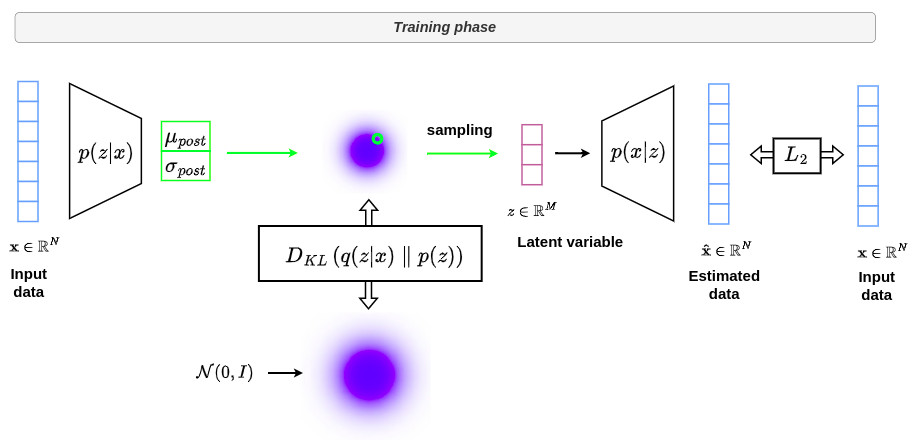

### Définition d'un CVAE

Le CVAE est une extension du VAE du point de vue de la structure. La différence réside dans le fait qu'on ajoute un deuxième conditionnement, $y$ qui donne des informations sur le contexte de la donnée d'entrée $x$. Par exemple, $x$ peut être une image et $y$ son label. D'une part, l'encodeur va apprendre $q(z|x,y)$, avec $z$ la représentation de $x$ dans l'espace latent. De la même manière qu'un VAE, encore une fois l'encodeur va apprendre $\mu(x,y)$ et $\sigma(x,y)$ de la distribution. De l'autre part, le décodeur va apprendre $p(x|z,y)$ : on trouve donc à la fois la représentation dans l'espace latent $z$ mais aussi le label $y$ dans l'entrée du décodeur. 

La fonction perte utilisée pour un CVAE est semblable à la fonction perte utilisée pour un VAE : 
$$Loss =  L(x, x') + \sum_{j=1}^{m} KL( q(z_j | x, y) \Vert \, p(z_j | y))$$
avec $L$ une fonction perte de reconstruction (MSE ou BCE), pour que les données en sortie soient proches des données d'entrée, et $KL$ la divergence Kullback-Leibler. De plus, on suppose que la distribution de l'espace latent est de la forme $p(z | y) \sim \mathcal{N}(0,1)$.

Après avoir entraîné le modèle, on peut créer de nouvelles données d'une classe spécifique en donnant $y$ le label de la donnée que l'on souhaite créer, et en échantillonnant un point de la distribution de l'espace latent (supposée normale). Alors que pour un VAE l'espace latent va décrire les différences entre les classes, l'espace latent d'un CVAE va décrire la différence entre les objets d'une même classe. Ainsi, en donnant un même échantillon de l'espace latent $z$ mais un label $y$ différent, le décodeur va fournir des images des différentes classes demandées, mais avec un même style car $z$ était similaire. 



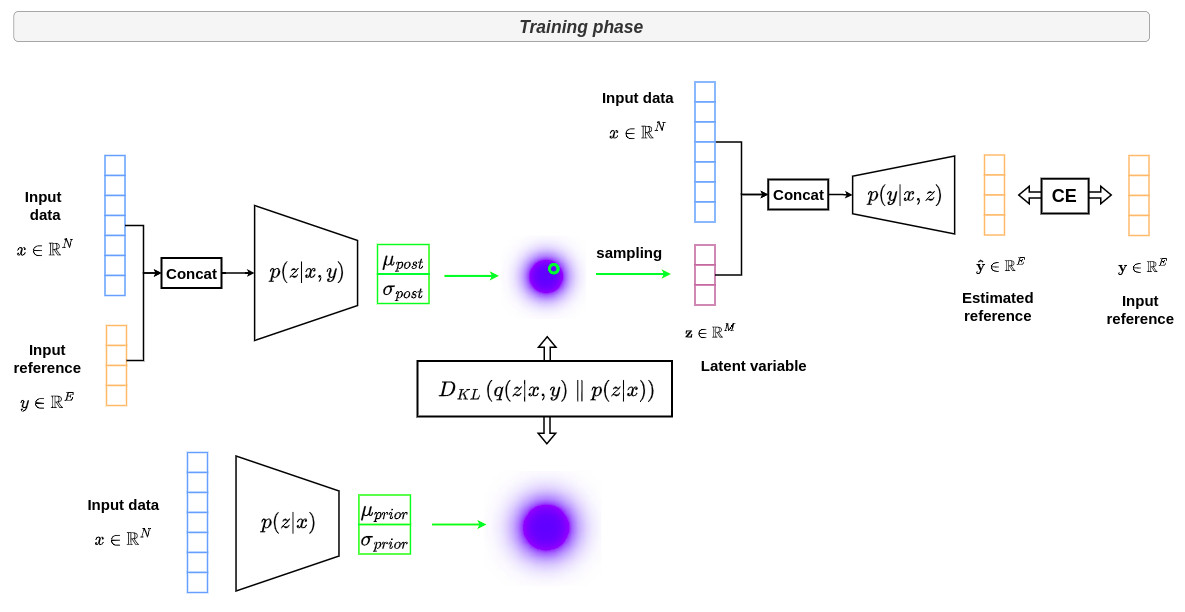

## Création du CVAE

In [1]:
# Maths
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Importation des données

In [4]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
img, label = train_dataset[0]
print("Image shape :", img.shape)

classes = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4: 'Coat',
    5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot' }

print(classes)


Image shape : torch.Size([1, 28, 28])
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


Le jeu de données Fashion MNIST comporte 70 000 images labellisées de taille $28 \times 28$.
Il y a 10 classes différentes, qui représentent différentes vêtements : 
- T-shirt 
- Pantlons
- Pull
- Robes
- Manteau
- Sandales
- Chemises
- Chaussures / baskets
- Sac
- Bottes

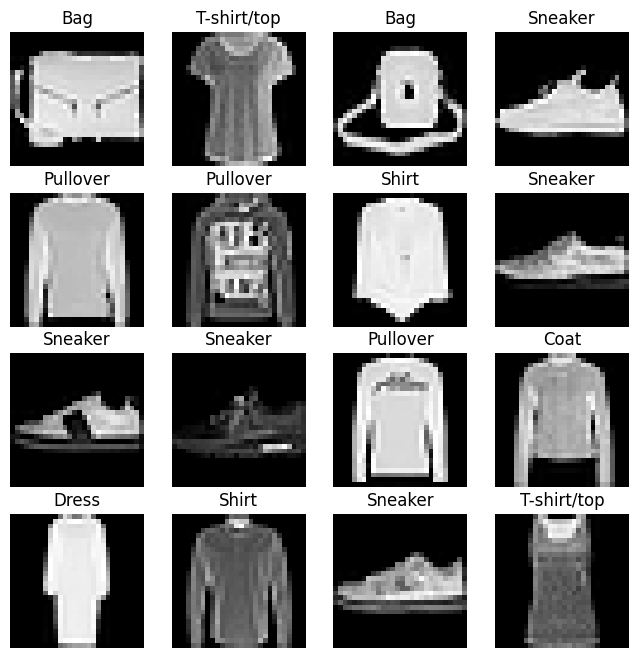

In [6]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(classes[labels[i].item()])
    #plt.title(labels[i].item())
    plt.axis("off")
plt.show()

In [7]:
labels = [label for _, label in train_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu d'apprentissage :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu d'apprentissage :
- Ankle Boot : 6000
- T-shirt/top : 6000
- Dress : 6000
- Pullover : 6000
- Sneaker : 6000
- Sandal : 6000
- Trouser : 6000
- Shirt : 6000
- Coat : 6000
- Bag : 6000


In [8]:
labels = [label for _, label in test_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu de test :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu de test :
- Ankle Boot : 1000
- Pullover : 1000
- Trouser : 1000
- Shirt : 1000
- Coat : 1000
- Sandal : 1000
- Sneaker : 1000
- Dress : 1000
- Bag : 1000
- T-shirt/top : 1000


### Défintion du CVAE

In [9]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10, embedding_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.flatten_size = 128 * 4 * 4

        # Conditional embedding
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # Latent space (with concatenated condition)
        self.fc_mu = nn.Linear(self.flatten_size + embedding_dim, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size + embedding_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + embedding_dim, 4 * 4 * 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.label_embedding(c)
        
        # Concatenate condition with encoded input
        x = torch.cat([x, c], dim=1)

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        c = self.label_embedding(c)
        # Concatenate condition with latent vector
        z = torch.cat([z, c], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.sample(mu, log_var)
        return self.decode(z, c), mu, log_var

In [10]:
def loss_function(recon_x, x, mu, logvar, beta = 1) :
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

EXPLICATION SUR LA STRUCTURE

The CVAE encoder consists of 3 convolutional layers each followed by a ReLU non-linearity. The output of the encoder is then flattened. The class number is then passed through an embedding layer and added to the encoder output. The reparameterization trick is then used with 2 linear layers to obtain a μ and σ in the latent space. Once sampled, the output of the reparameterized latent space is passed to the decoder now concatenated with the class number embedding layer output. The decoder consists of 3 transposed convolutional layers. The first two contain a ReLU non-linearity with the last layer containing a sigmoid non-linearity. The output of the decoder is a 28×28 generated image.

The other model architecture follows the same approach but with adding the conditional input instead of concatenating. A major question was if adding or concatenating will lead to better reconstruction or generation results.

on choisit concat plutôt que add car meilleurs résultats 
on choisit embedding plutôt que one hot 

## Entraînement du CVAE

In [11]:
# Paramètres
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta_1 = 1
beta_2 = 10
beta_3 = 50

In [12]:
# Premier CVAE avec beta = 1
cvae1 = ConditionalVAE(latent_dim=latent_dim, num_classes=10)
cvae1.to(device)
optimizer = optim.Adam(cvae1.parameters(), lr=learning_rate)


for epoch in range(1, epochs + 1):
    cvae1.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae1(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta_1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 286.6513
Epoch 2, Training loss: 258.8761
Epoch 3, Training loss: 256.5048
Epoch 4, Training loss: 255.3210
Epoch 5, Training loss: 254.5993
Epoch 6, Training loss: 253.9730
Epoch 7, Training loss: 253.6058
Epoch 8, Training loss: 253.3085
Epoch 9, Training loss: 252.9560
Epoch 10, Training loss: 252.8021
Epoch 11, Training loss: 252.5872
Epoch 12, Training loss: 252.4604
Epoch 13, Training loss: 252.2736
Epoch 14, Training loss: 252.1088
Epoch 15, Training loss: 252.0201
Epoch 16, Training loss: 251.8700
Epoch 17, Training loss: 251.7265
Epoch 18, Training loss: 251.6461
Epoch 19, Training loss: 251.5635
Epoch 20, Training loss: 251.4372
Epoch 21, Training loss: 251.3821
Epoch 22, Training loss: 251.2421
Epoch 23, Training loss: 251.1571
Epoch 24, Training loss: 251.1342
Epoch 25, Training loss: 251.0114
Epoch 26, Training loss: 250.9434
Epoch 27, Training loss: 250.9159
Epoch 28, Training loss: 250.7836
Epoch 29, Training loss: 250.7784
Epoch 30, Training loss

In [13]:
# Deuxième CVAE avec beta = 10
cvae2 = ConditionalVAE(latent_dim=latent_dim, num_classes=10)
cvae2.to(device)
optimizer = optim.Adam(cvae2.parameters(), lr=learning_rate)


for epoch in range(1, epochs + 1):
    cvae2.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae2(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta_2)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 312.1036
Epoch 2, Training loss: 282.3099
Epoch 3, Training loss: 280.3661
Epoch 4, Training loss: 279.6308
Epoch 5, Training loss: 279.1462
Epoch 6, Training loss: 278.7689
Epoch 7, Training loss: 278.4781
Epoch 8, Training loss: 278.2501
Epoch 9, Training loss: 278.0547
Epoch 10, Training loss: 277.9180
Epoch 11, Training loss: 277.7104
Epoch 12, Training loss: 277.6858
Epoch 13, Training loss: 277.4946
Epoch 14, Training loss: 277.5884
Epoch 15, Training loss: 277.4475
Epoch 16, Training loss: 277.3903
Epoch 17, Training loss: 277.1755
Epoch 18, Training loss: 277.2801
Epoch 19, Training loss: 277.1286
Epoch 20, Training loss: 277.1853
Epoch 21, Training loss: 277.0257
Epoch 22, Training loss: 276.9369
Epoch 23, Training loss: 276.9614
Epoch 24, Training loss: 276.9119
Epoch 25, Training loss: 276.7414
Epoch 26, Training loss: 276.8722
Epoch 27, Training loss: 276.8378
Epoch 28, Training loss: 276.7841
Epoch 29, Training loss: 276.8663
Epoch 30, Training loss

In [14]:
# Troisième CVAE avec beta = 50
cvae3 = ConditionalVAE(latent_dim=latent_dim, num_classes=10)
cvae3.to(device)
optimizer = optim.Adam(cvae3.parameters(), lr=learning_rate)


for epoch in range(1, epochs + 1):
    cvae3.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae3(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar, beta_3)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 322.4759
Epoch 2, Training loss: 307.7821
Epoch 3, Training loss: 307.5635
Epoch 4, Training loss: 307.2609
Epoch 5, Training loss: 306.5927
Epoch 6, Training loss: 306.0526
Epoch 7, Training loss: 306.1509
Epoch 8, Training loss: 306.0572
Epoch 9, Training loss: 305.9883
Epoch 10, Training loss: 306.0464
Epoch 11, Training loss: 305.6283
Epoch 12, Training loss: 305.7017
Epoch 13, Training loss: 305.5620
Epoch 14, Training loss: 305.6557
Epoch 15, Training loss: 305.5307
Epoch 16, Training loss: 305.7887
Epoch 17, Training loss: 305.5123
Epoch 18, Training loss: 305.6216
Epoch 19, Training loss: 305.6577
Epoch 20, Training loss: 305.5163
Epoch 21, Training loss: 305.4685
Epoch 22, Training loss: 305.5725
Epoch 23, Training loss: 305.4261
Epoch 24, Training loss: 305.4542
Epoch 25, Training loss: 305.4504
Epoch 26, Training loss: 305.4422
Epoch 27, Training loss: 305.4528
Epoch 28, Training loss: 305.3393
Epoch 29, Training loss: 305.2451
Epoch 30, Training loss

In [17]:
def comparison_images(im1, im2, im3, im4, n_images=6):
    fig, ax = plt.subplots(4, n_images, figsize=(20, 6))
    
    for i in range(n_images):
        mse1 = np.mean((im1[i] - im2[i]) ** 2)
        mse2 = np.mean((im1[i] - im3[i]) ** 2)
        mse3 = np.mean((im1[i] - im4[i]) ** 2)
        
        psnr1 = 10 * np.log10(1.0 / mse1)
        psnr2 = 10 * np.log10(1.0 / mse2)
        psnr3 = 10 * np.log10(1.0 / mse3)

        # Plot original images
        ax[0, i].imshow(im1[i], cmap='gray')
        ax[0, i].axis('off')    
        ax[0,]

        # Images reconstruites avec beta = 1
        ax[1, i].imshow(im2[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1,i].set_title(f"MSE : {mse1:.4}, PSNR : {psnr1:.4}")
        
        # Images reconstruites avec beta = 10
        ax[2, i].imshow(im3[i], cmap='gray')
        ax[2, i].axis('off')
        ax[2,i].set_title(f"MSE : {mse2:.4}, PSNR : {psnr2:.4}")
        
        # Images reconstruites avec beta = 50
        ax[3, i].imshow(im4[i], cmap='gray')
        ax[3, i].axis('off')
        ax[3,i].set_title(f"MSE : {mse3:.4}, PSNR : {psnr3:.4}")
        
    fig.suptitle("Images originales (haut) vs images reconstruites (bas) pour beta = 1, 10 et 50")
    
    plt.tight_layout()
    plt.show()

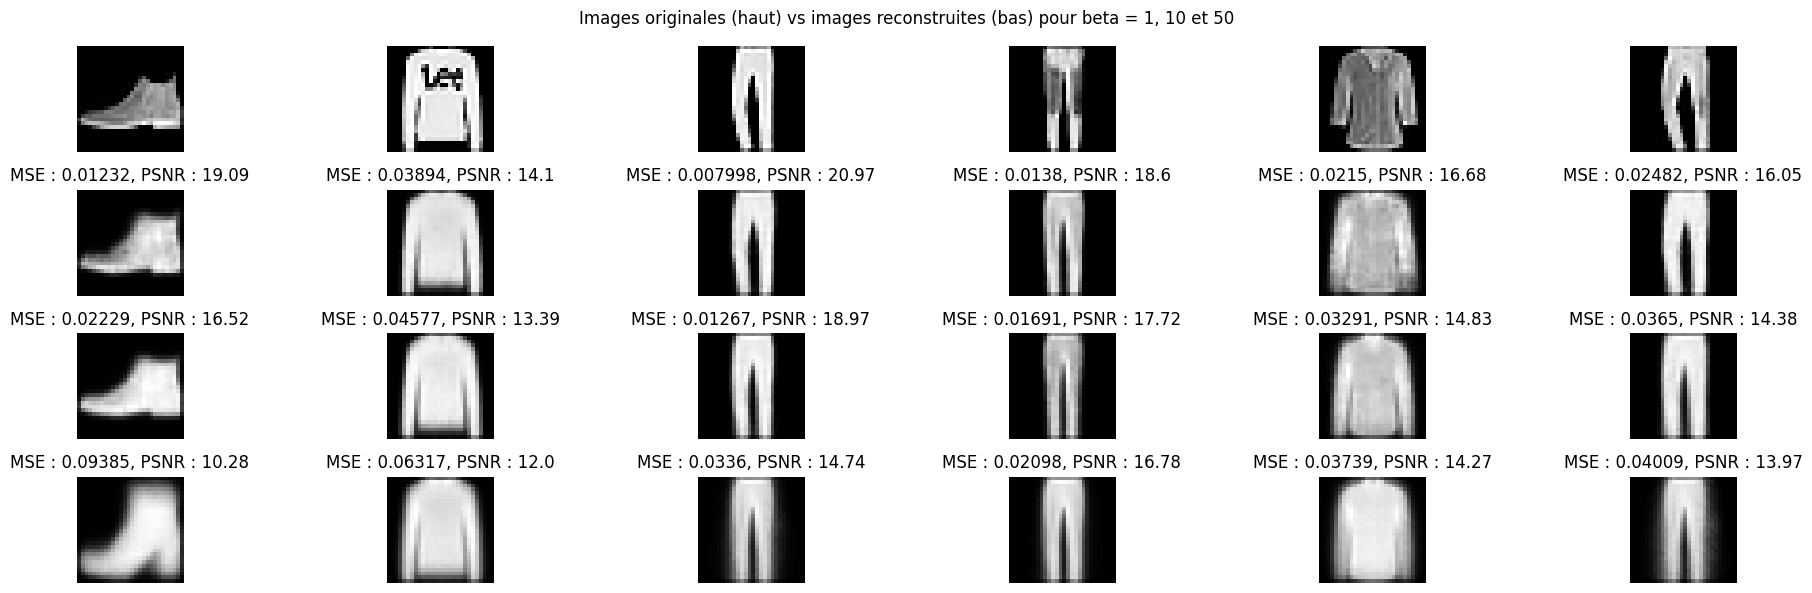

In [18]:
cvae1.eval()
cvae2.eval()
cvae3.eval()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    recons1, _, _ = cvae1(images, labels)
    recons2, _, _ = cvae2(images, labels)
    recons3, _, _ = cvae3(images, labels)

    # Conversion en NumPy pour l'affichage
    images_np = images.cpu().numpy().squeeze(1)
    recons1_np = recons1.cpu().numpy().squeeze(1)
    recons2_np = recons2.cpu().numpy().squeeze(1)
    recons3_np = recons3.cpu().numpy().squeeze(1)

# Affichage
comparison_images(images_np, recons1_np, recons2_np, recons3_np, n_images=6)


Nous pouvons voir la reconstruction des photos par les différents CVAE que nous avons entraîné. Afin d'étudier la validité de la reconstruction, nous utilisons 2 métriques : 
- la MSE (Mean Squared Error) : la somme des carrés des différences . Une MSE plus faible indique donc une image reconstruite plus proche de l'image originale.
- le PSNR () : .... . Un PSNR plus élevé signifie que l'image reconstruite est plus fidèle à l'image de base.

A l'oeil, et en s'aidant des métriques, on peut voir qu'avec un beta plus faible (1 ou 10) les images sont mieux reconstruites. Cela ne signifie pas que les images de sortie du troisième CVAE ne ressemblent pas aux vêtements, au contraire, simplement qu'elles ressemblent moins à l'image de base. 

## Création de 5 échantillons de chaque classe 

In [19]:
num_classes = 10
n_samples = 5
zs = torch.randn(n_samples, latent_dim, device=device)
    
all_generated1 = []
all_generated2 = []
all_generated3 = []

with torch.no_grad():
    for z in zs : 
        z = z.unsqueeze(0).repeat(num_classes, 1)
        labels = torch.arange(num_classes, device = device)
        generated1 = cvae1.decode(z, labels)  # décodage conditionnel
        generated2 = cvae2.decode(z, labels) 
        generated3 = cvae3.decode(z, labels) 
        all_generated1.append(generated1.cpu().numpy())
        all_generated2.append(generated2.cpu().numpy())
        all_generated3.append(generated3.cpu().numpy())
        
all_generated1 = np.concatenate(all_generated1, axis=0)  # (5*10, 1, 28, 28)
all_generated1 = all_generated1.squeeze(1)      

all_generated2 = np.concatenate(all_generated2, axis=0)  # (5*10, 1, 28, 28)
all_generated2 = all_generated2.squeeze(1)     

all_generated3 = np.concatenate(all_generated3, axis=0)  # (5*10, 1, 28, 28)
all_generated3 = all_generated3.squeeze(1)       
#


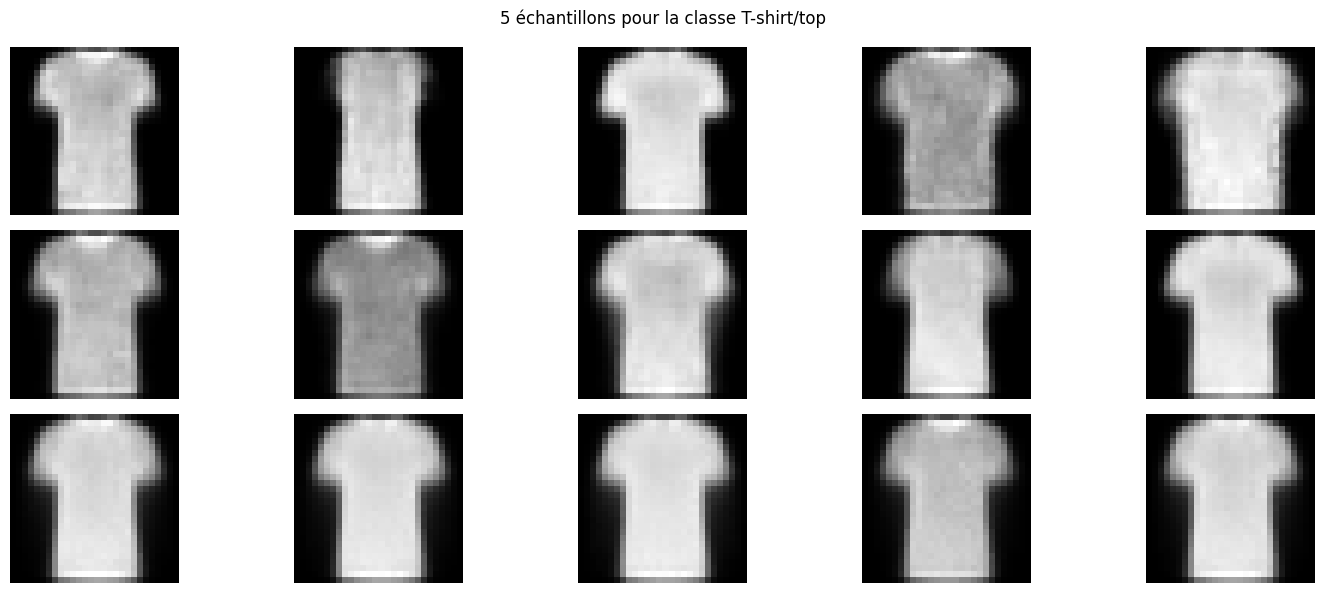

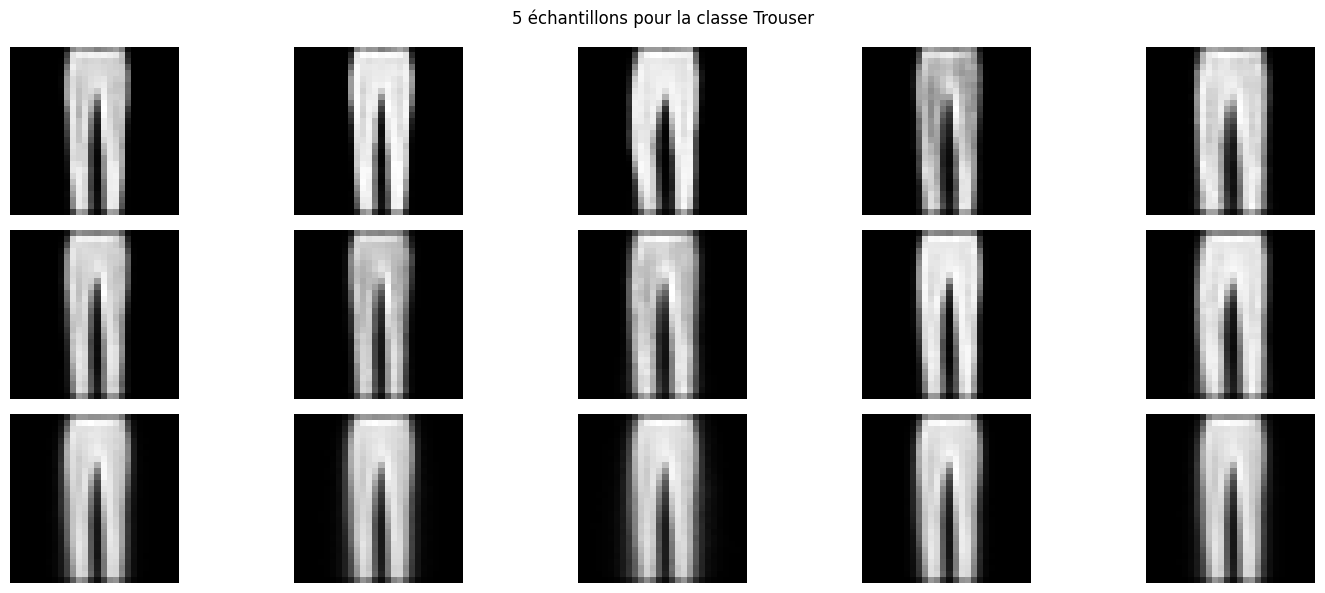

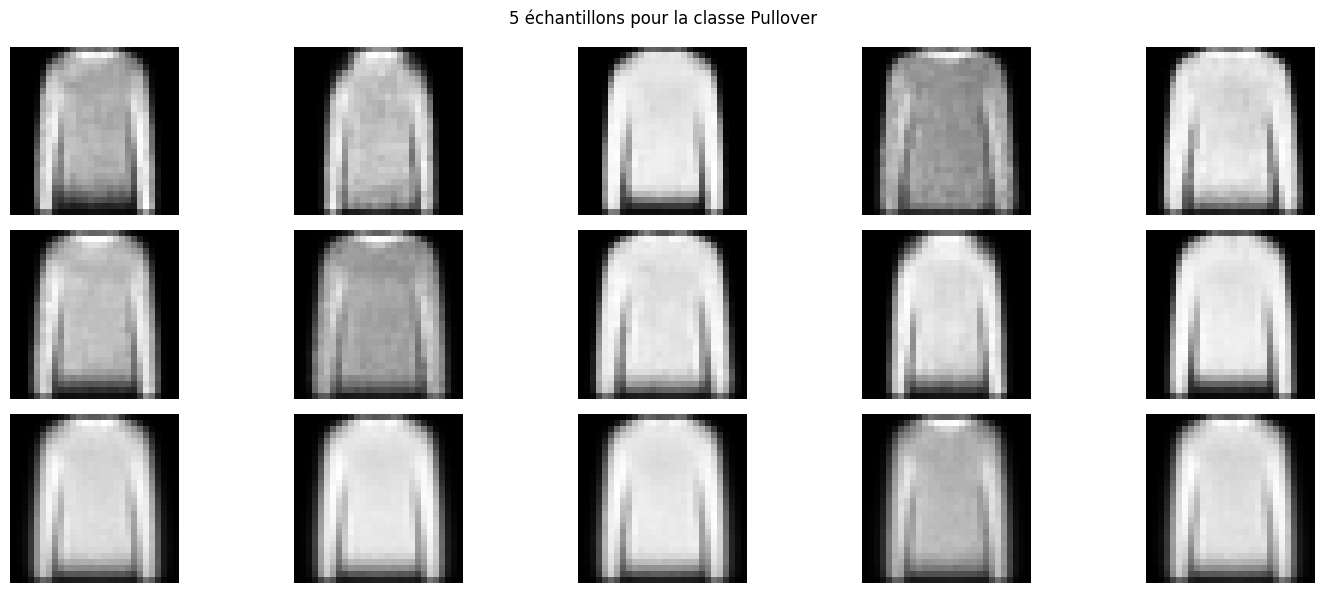

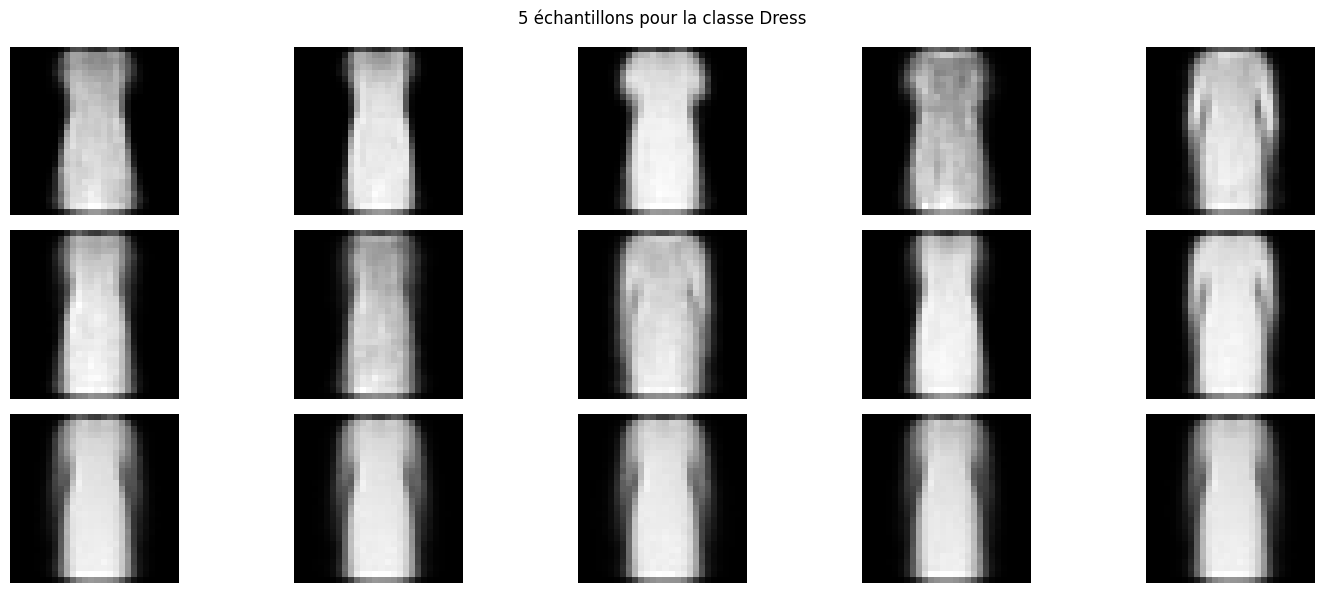

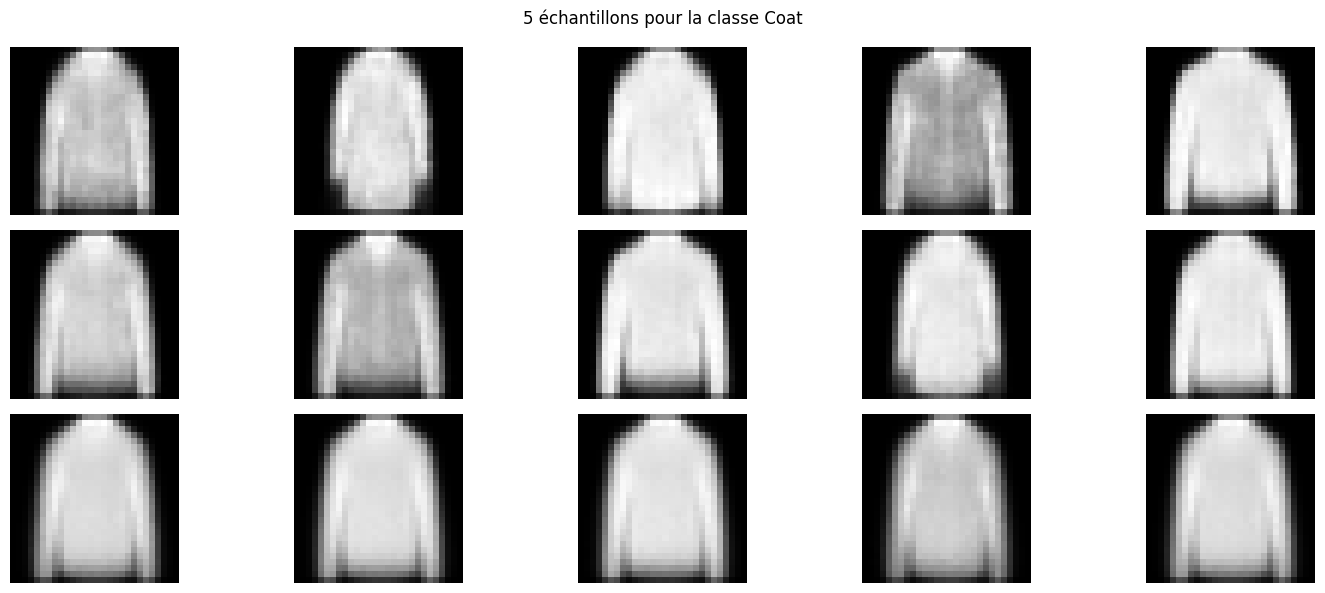

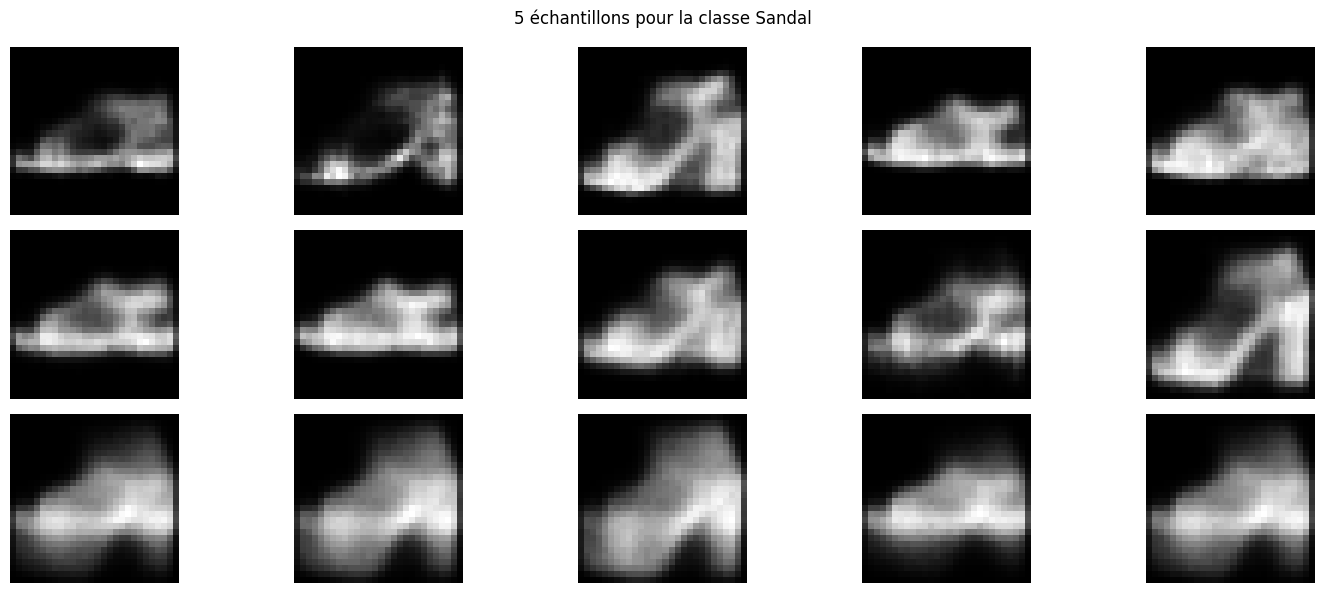

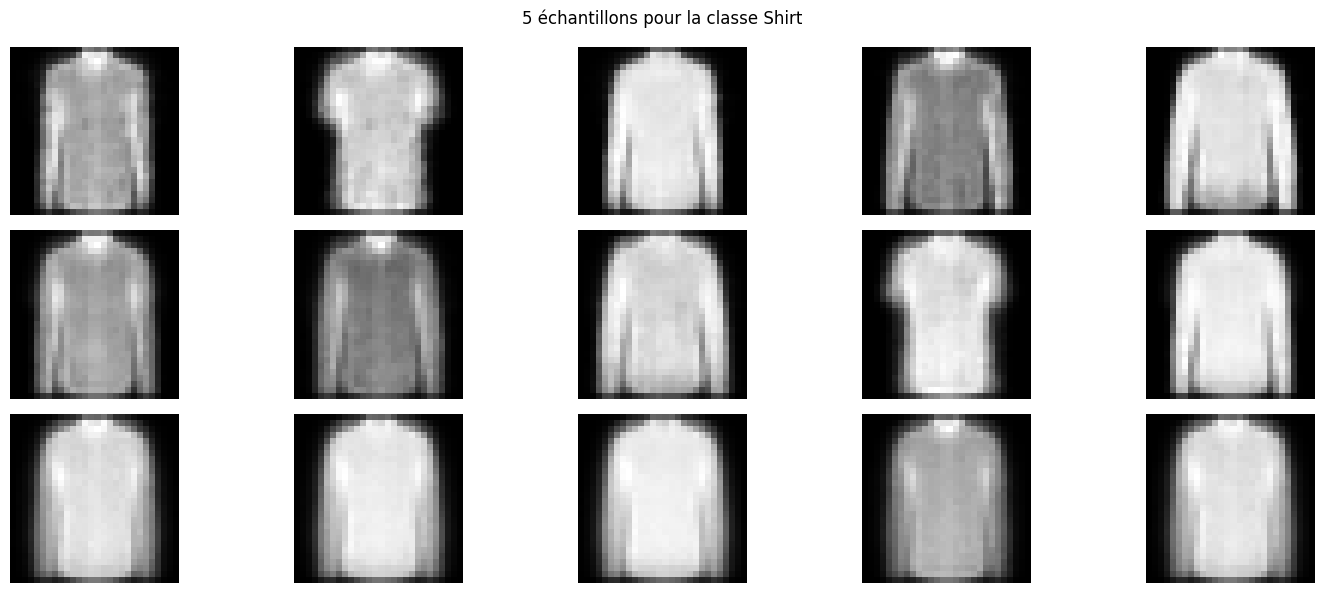

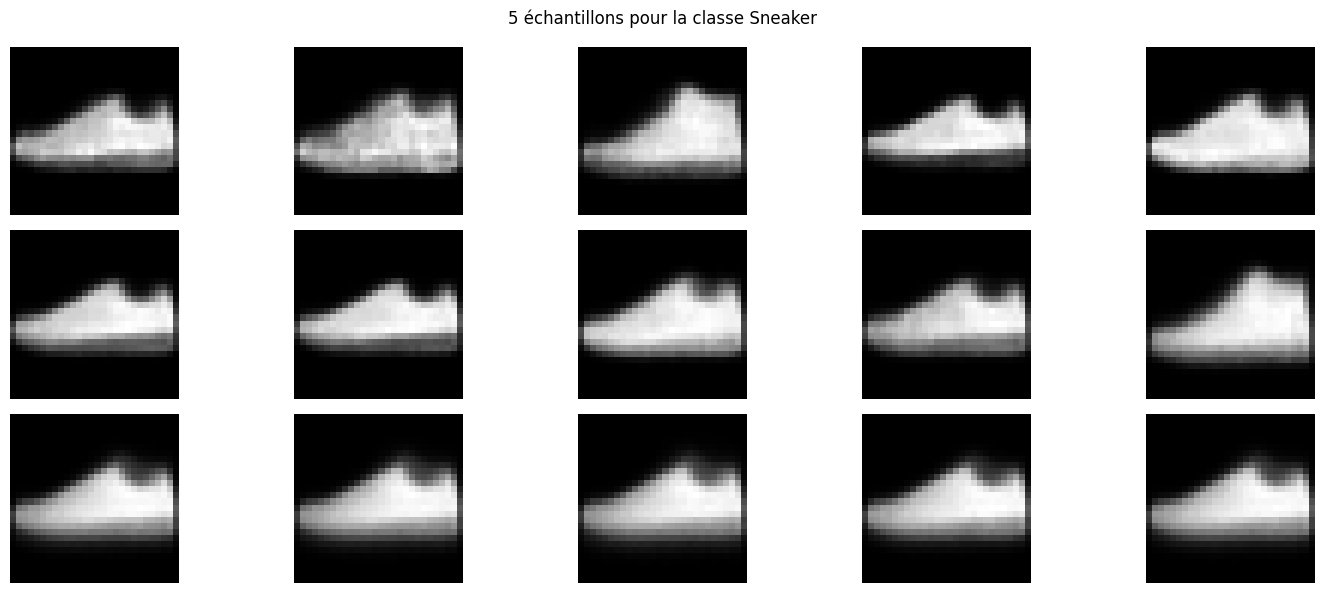

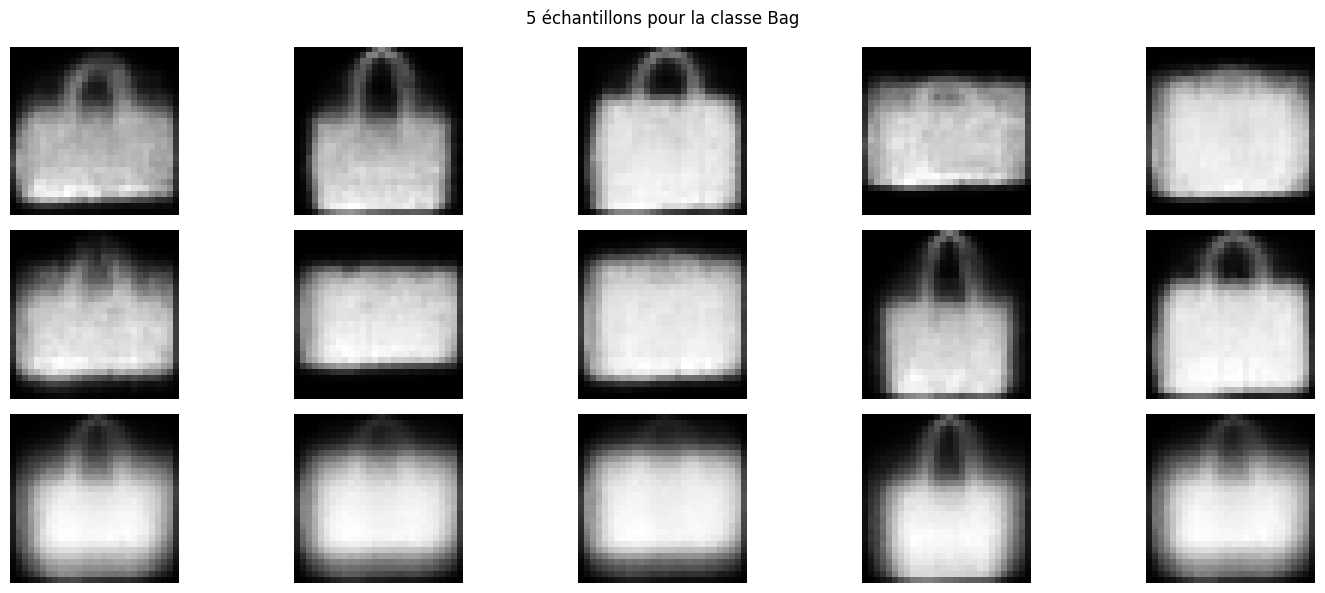

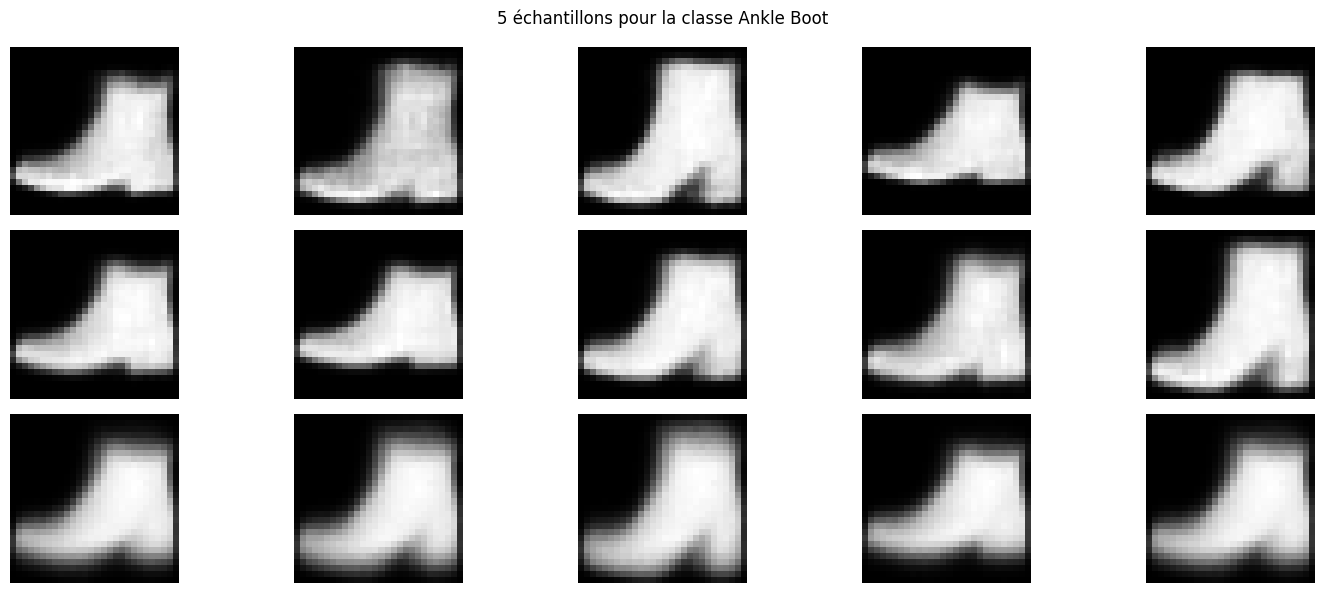

In [20]:
for i in range(num_classes):
    fig, ax = plt.subplots(3, n_samples, figsize=(15, 6))
    for j in range(n_samples):     # colonne = classe
        idx = j * num_classes + i
        ax[0, j].imshow(all_generated1[idx], cmap='gray')
        ax[0, j].axis('off')
        
        ax[1, j].imshow(all_generated2[idx], cmap='gray')
        ax[1, j].axis('off')
        
        ax[2, j].imshow(all_generated3[idx], cmap='gray')
        ax[2, j].axis('off')
        #ax[0, j].set_title(f"Sample {z[i]:.3}", fontsize=12)  # ligne
        fig.suptitle(f"{n_samples} échantillons pour la classe {classes[i]}")
    plt.tight_layout()
    plt.show()

Nous avons pris les 5 mêmes échantillons de l'espace latent pour reconstruire les images de chaque classe. La première ligne correspond au CVAE avec $\beta = 1$, la deuxième ligne pour $\beta = 10$ et la troisième pour $\beta = 50$.

Le fait d'avoir pris les 5 mêmes échantillons pour chaque catégorie donne des résultats "similaires", dans le sens où on a des images de même luminosité par exemple. 

Les trois lignes reconstruisent flobalement des images dans le même style (par exemple pour les chaussures, des t-shirts à manche longue, même forme de sac...). Cependant, il y a bien plus de différences entre les images construites par le troisième CVAE que les images construites par les deux premiers CVAE. Cela est sans doute signe d'une distribution de l'espace latente semblable pour les deux premiers CVAE, et qui diffère pour le troisième. 

Comme la dimension de l'espace latent du modèle est de 2, on peut le visualiser pour les tris CVAE.

In [23]:
def plot_latent_space(model, zs):
    model.eval()
    latents = []
    labels_list = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            mu, _ = model.encode(data, labels)
            latents.append(mu.cpu())
            labels_list.append(labels.cpu())

    latents = torch.cat(latents, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    # Scatter par classe
    for i in range(10):
        idxs = labels_list == i
        plt.scatter(latents[idxs, 0], latents[idxs, 1], label=classes[i], alpha=0.5)

    # Ajouter les z fournis sur le graphe
    for i, z in enumerate(zs):
        z = z.cpu().numpy()
        plt.scatter(z[0], z[1], marker='x', color='red', s=100, label=f'z {i}' if i==0 else None)

    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(f"Représentation de l'espace latent du modèle")
    plt.legend()
    #plt.tight_layout(rect=[0,0,1,0.95])
    plt.ylim(-5, 5)
    plt.xlim(-5, 5)
    plt.show()


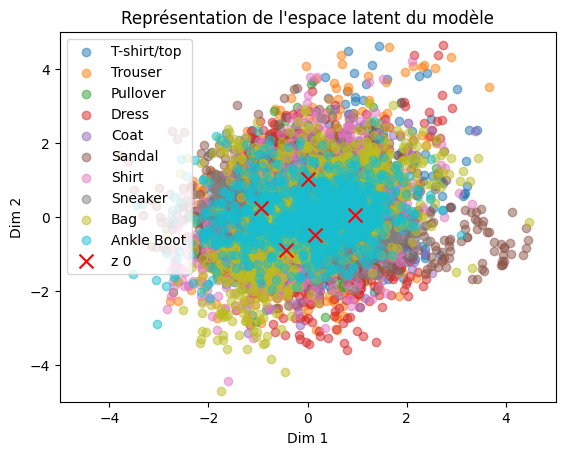

In [25]:
plot_latent_space(cvae1, zs)

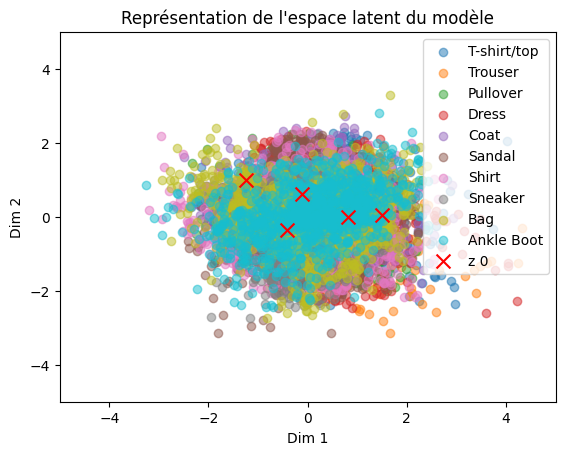

In [60]:
plot_latent_space(cvae2, zs)

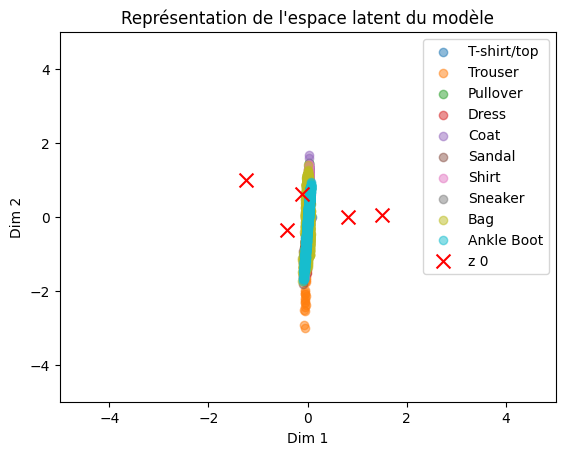

In [61]:
plot_latent_space(cvae3, zs)

Les trois CVAE ont des espaces latent complétements différents, et de forme bien différente. Cependant, la distribution de l'espace latent conditionnellement à chaque classe est censée suivre une $\mathcal{N}(0, 1)$, il doit donc avoir la même forme. 

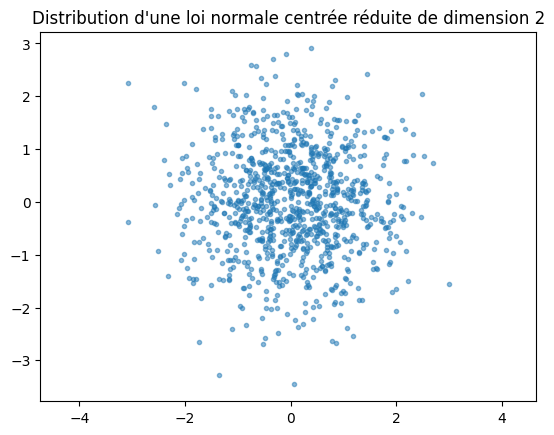

In [74]:
z = np.random.multivariate_normal((0, 0), np.diag([1,1]), 1000) 
plt.plot(z[:, 0], z[:, 1], '.', alpha=0.5)
plt.axis('equal')
plt.title("Distribution d'une loi normale centrée réduite de dimension 2")
plt.show()

L'espace latent est censé ressembler à la distribution d'une loi normale $\mathcal{N}(0, I_2)$, qui peut être visualisée sur le dernier graphe. Ainsi, pour un $\beta$ plus faible, les espaces latents ont la même forme que la distribution de lois normales centrées réduites. Cependant, pour un $\beta$ plus grand, ça ne ressemble absolument pas à la distribution d'une loi normale centrée réduite. Ce qui est contraire à ce qu'on pourrait attendre, car un $\beta$ plus élevé donne plus de poids à la KL-divergence dans le loss. Or, comme nous l'avons expliqué, c'est elle qui force la distribution de l'espace latent à ressembler à être proche d'une loi normale centrée réduite : on s'attendait donc à avoir un espace latent plus proche d'un cercle sur le dernier graphe, contrairement aux deux premiers. 

EXPLIQUER POURQUOI CETTE FORME

# Sources

https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#cvae


https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb/

Entity Embeddings of Categorical Variables (Guo & Berkhahn, 2016)
Deep label embedding learning for classification
Beyond one-hot encoding: Lower dimensional target embedding
Conditional Variational Autoencoders (SID 2025) : mentionne que pour petits espaces de labels on peut utiliser one-hot, mais pour accords de grande cardinalité, des embeddings appris sont préférables pour capturer la structure des conditions

https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf (forme de la fonction perte)